In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import os
import ROOT
import datetime
from root_numpy import root2array, root2rec, tree2rec, array2root
from scipy.optimize import curve_fit
from scipy.misc import factorial
plt.rcParams.update({'font.size': 16})
#from larlite import larlite
#k=larlite.trigger()
from ROOT import larlite
larlite.trigger()
from ROOT import fememu
from fememu_pycfg import apply_config


In [2]:
# emulator configuration
cfg_file = 'debug_teststand.cfg'
config = fememu.FEMBeamTriggerConfig()
apply_config(config,cfg_file)
# emulator construction
emu = fememu.LLInterface(config)
# data file loading
f_trig = ROOT.TFile('debug_trig.root')
f_xmit = ROOT.TFile('debug_fifo.root')
t_trig = f_trig.Get('trigger_daq_tree')
t_xmit = f_xmit.Get('fifo_pmt_xmit_tree')
print 'trigger entries :',t_trig.GetEntries()
print 'xmit entries    :',t_xmit.GetEntries()


trigger entries : 97
xmit entries    : 91


In [3]:
trig_times = {}
for x in xrange(t_trig.GetEntries()):
    t_trig.GetEntry(x)
    trig = t_trig.trigger_daq_branch
    trig_num  = trig.TriggerNumber()
    trig_time = trig.TriggerTime()
    trig_frame = int(trig_time /1600.)
    trig_sample = (trig_time - trig_frame * 1600.) / (1./64.)
    trig_times[trig.TriggerNumber()] = (trig_time,trig_frame,trig_sample)

# find first saturation tick number
def getFireTick(vec):
    for idx in xrange(len(vec)):
        if idx < 3: continue
        if vec[idx] - vec[idx-3] > 100: 
            return idx

Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ 56
Emulator fire @ 56
Emulator fire @ 56
Emulator fire @ 58
Emulator fire @ 58
Emulator fire @ 58
Emulator fire @ 58
Emulator fire @ 58
Emulator fire @ 59
Emulator fire @ 59
Emulator fire @ 59
Emulator fire @ 59
Emulator fire @ 59
Emulator fire @ 60
Emulator fire @ 60
Emulator fire @ 60
Emulator fire @ 61
Emulator fire @ 62
Emulator fire @ 62
Emulator fire @ 62
Emulator fire @ 62
Emulator fire @ 62
Emulator fire @ 63
Emulator fire @ 63
Emulator fire @ 64
Emulator fire @ 65
Emulator fire @ 65
Emulator fire @ 65
Emulator fire @ 65
Emulator fire @ 66
Emulator fire @ 66
Emulator fire @ 66
Emulator fire @ 67
Emulator fire @ 67
Emulator fire @ 67
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 69
Emulator fire @ 69
Emulator fire @ 69
Emulator fir

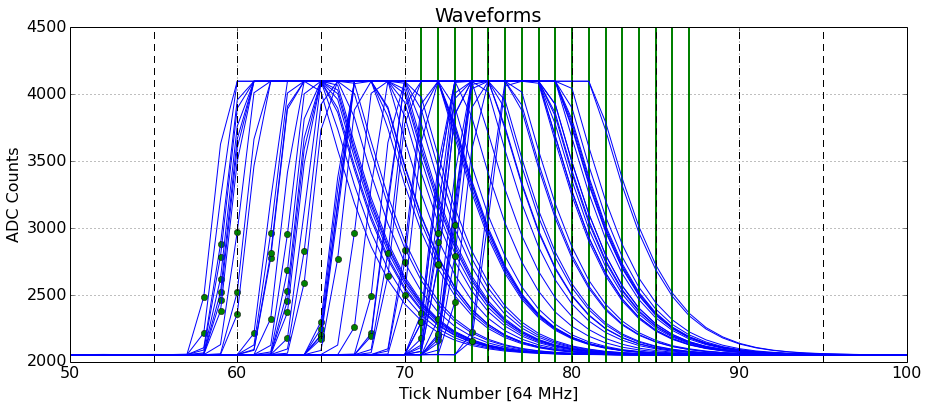

In [4]:
show_ch1 = False
fig = plt.figure(figsize=(15,6))
# loop through xmit info
for x in xrange(t_xmit.GetEntries()):
    t_xmit.GetEntry(x)
    t_trig.GetEntry(x)
    ev_fifo = t_xmit.fifo_pmt_xmit_branch
    frame_num = sample_num = 0
    
    ch0,ch1,beamch=(None,None,None)

    for n in xrange(ev_fifo.size()):
        fifo = ev_fifo[n]
        if not fifo.module_address() == 5: continue
        channel = fifo.channel_number()
        
        if channel == 0: 
            ch0 = fifo
        elif channel == 1:
            ch1 = fifo
        elif channel in [46,47]:
            beamch = fifo

    ch0_adc = np.array(ch0)
    ch1_adc = np.array(ch1)
    beamch_adc = np.array(beamch)

    # Get timings
    beamgate_sample = ch0.readout_sample_number_RAW()
    
    trig_num = ev_fifo.event_number()
    trig_time,trig_frame,trig_sample = trig_times[trig_num]
    trig_tick = trig_sample - beamgate_sample

    beamch_tick = beamch.readout_sample_number_RAW() - beamgate_sample
    beamch_fire = getFireTick(beamch_adc)

    if trig_tick < 0 or trig_tick > 100: continue
        
    plt.plot(ch0,label='Ch. 0 ADC Values',color='b')
    
    plt.axvline(trig_tick,color='g',lw=2,label='Trigger (Tick %d)' % trig_tick)
            
    # get saturation tick for ch1
    ch0_fire = getFireTick(ch0_adc)
    plt.plot(ch0_fire,ch0_adc[ch0_fire],'go',label='Ch. 0 PHMAX > 100 @ %d' % ch0_fire)
    if show_ch1:
        ch1_fire = getFireTick(ch1_adc)
        plt.plot(ch1,label='Ch. 1 ADC Values ',color='r')
        plt.plot(ch1_fire,ch1_adc[ch1_fire],'go',label='Ch. 1 PHMAX > 100 @ %d' % ch1_fire)

    for x in xrange(100):
        plt.axvline(x*5,color='k',alpha=0.5,linestyle='--')
        
    #print ch0_fire,trig_tick
    # Emulator
    emu_out = emu.Emulate(ev_fifo)
    print 'Emulator fire @',
    emu_fired = False
    for t in emu_out.fire_time_v:
        print t,
        if t >= 0: emu_fired = True
    print
    
plt.grid()
#plt.legend()
plt.xlim(50,100)
plt.xlabel('Tick Number [64 MHz]')
plt.ylabel('ADC Counts')
plt.title('Waveforms')
plt.show()


Emulator fire @ -1


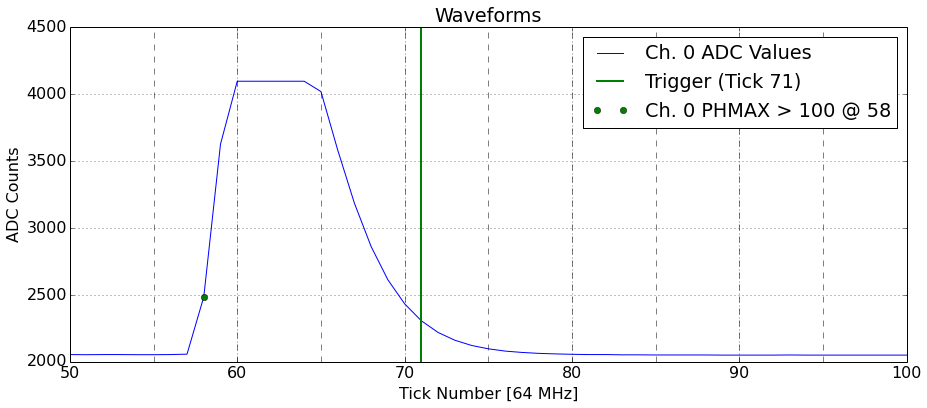

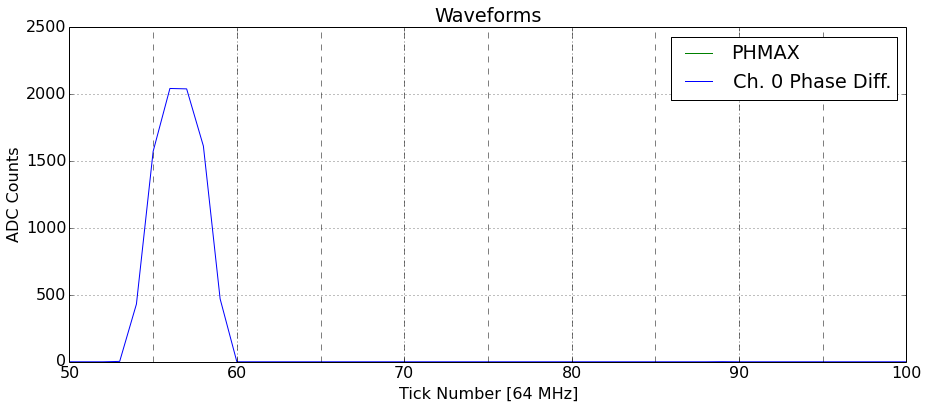

Emulator fire @ -1


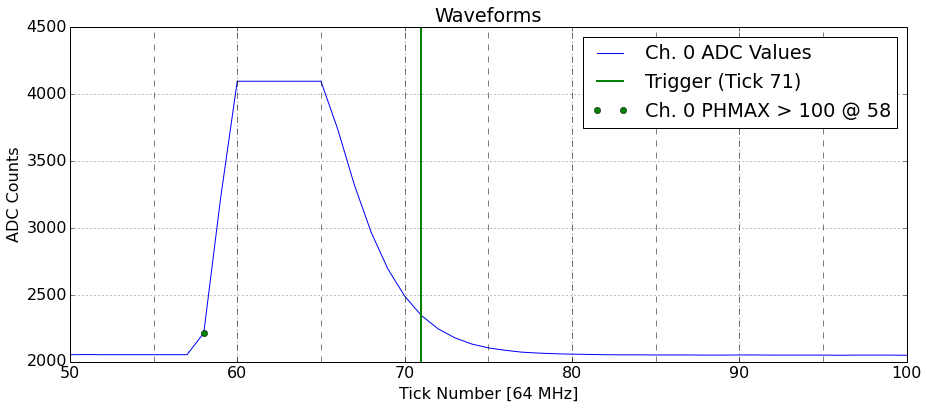

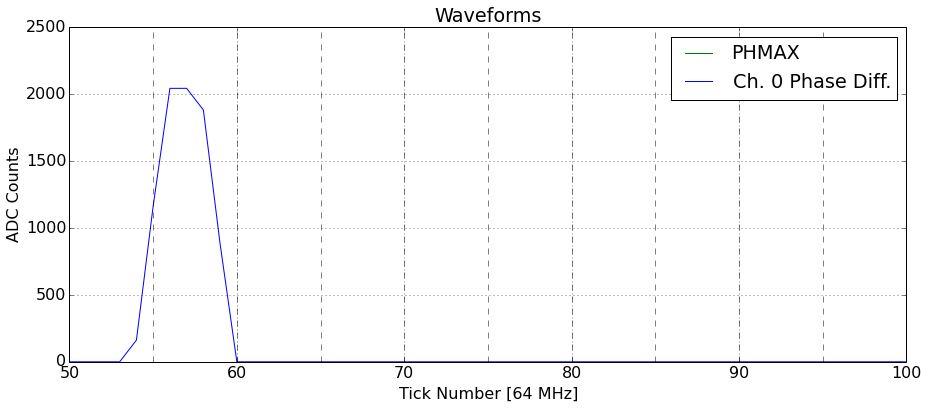

Emulator fire @ -1


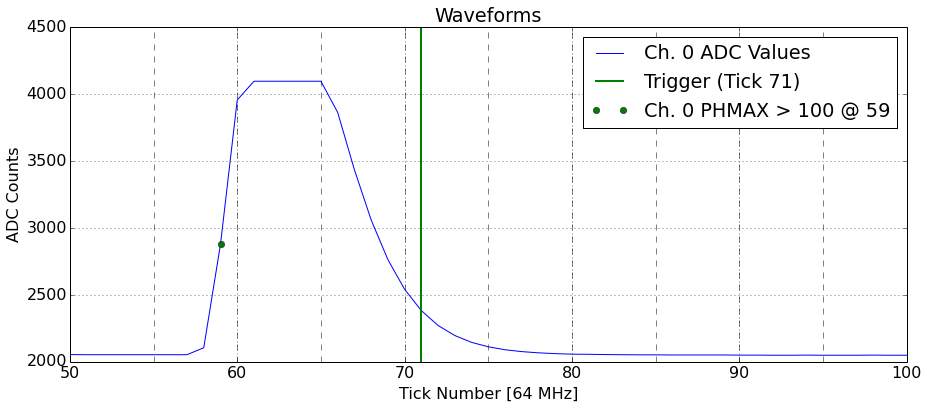

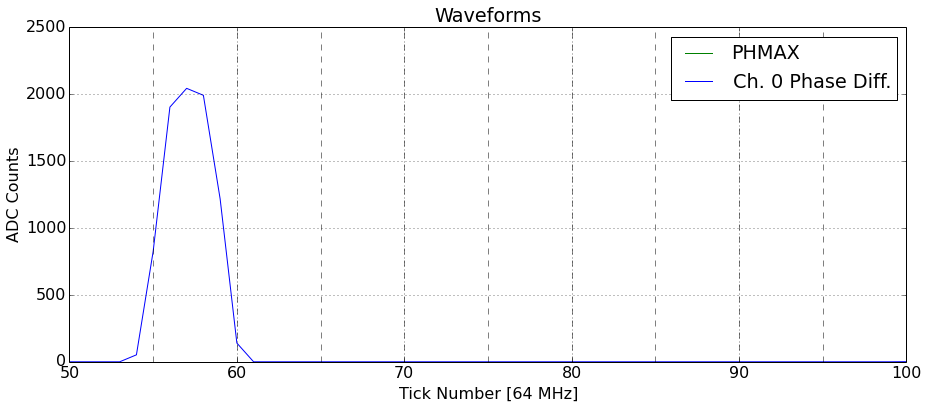

Emulator fire @ -1


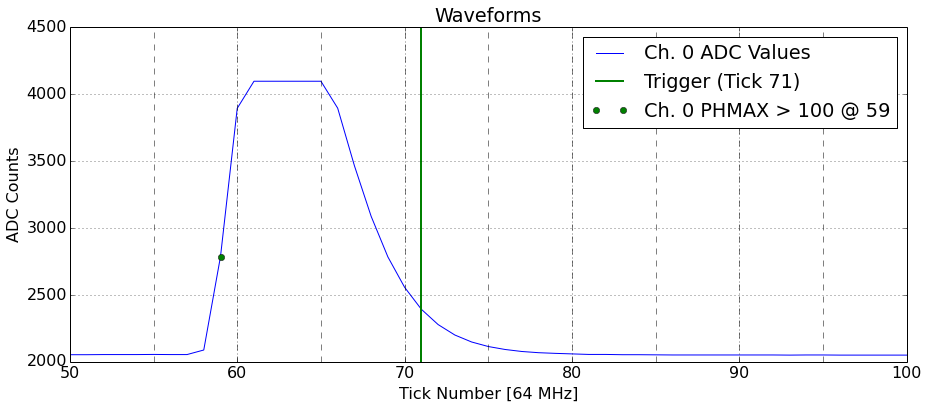

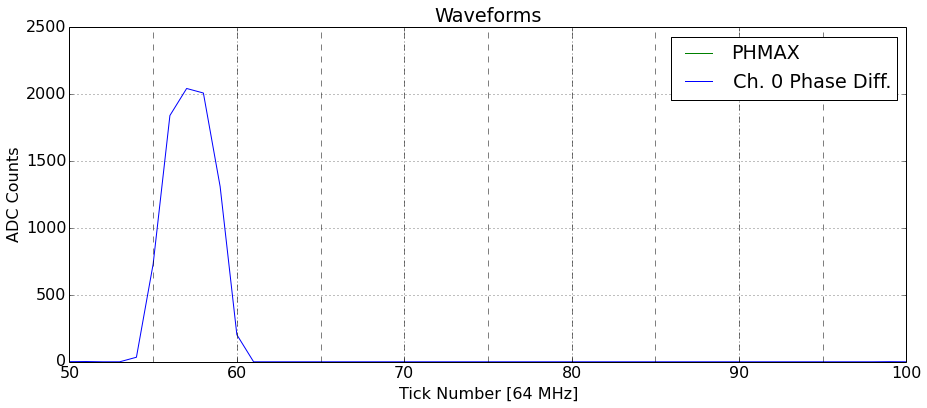

Emulator fire @ -1


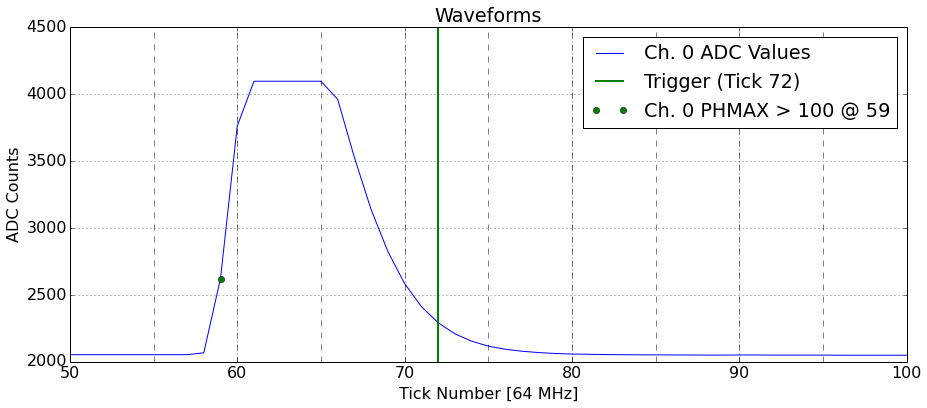

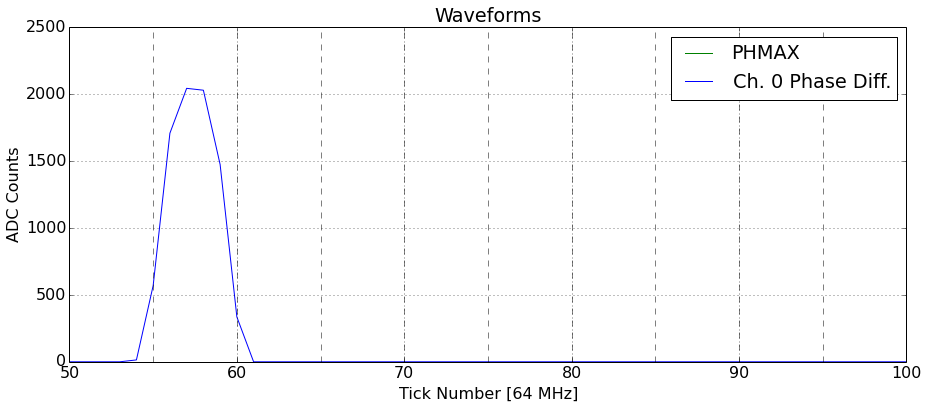

Emulator fire @ -1


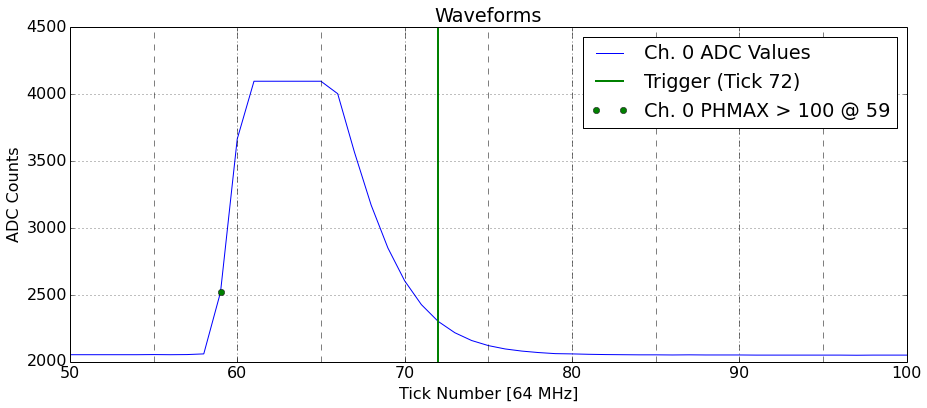

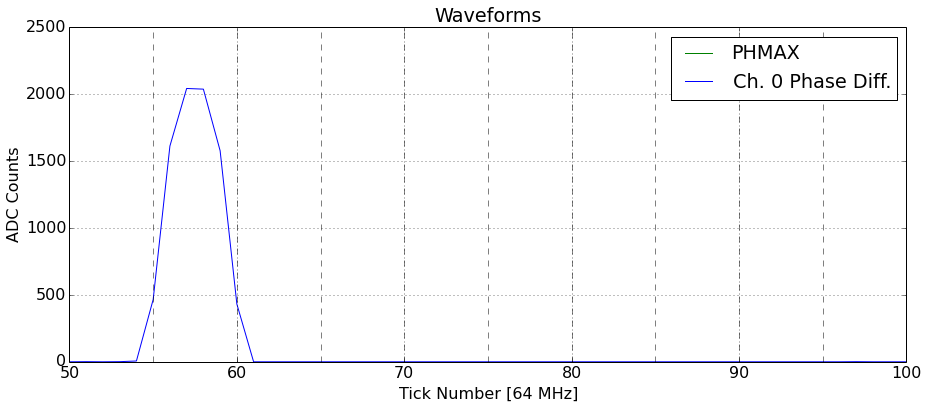

Emulator fire @ -1


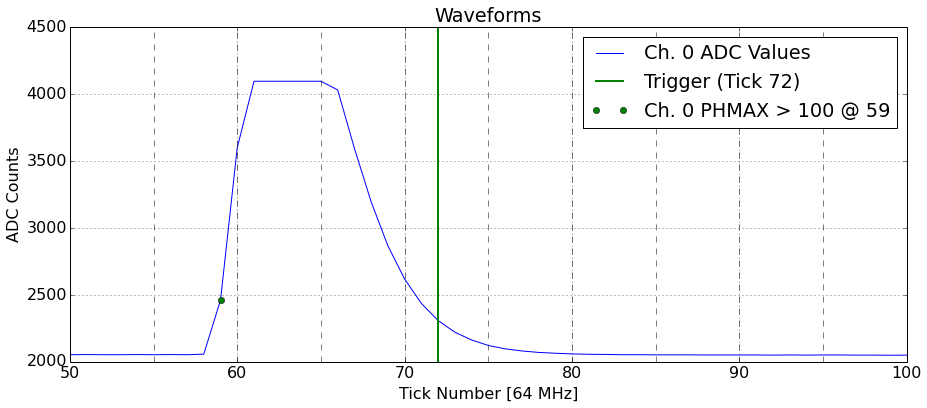

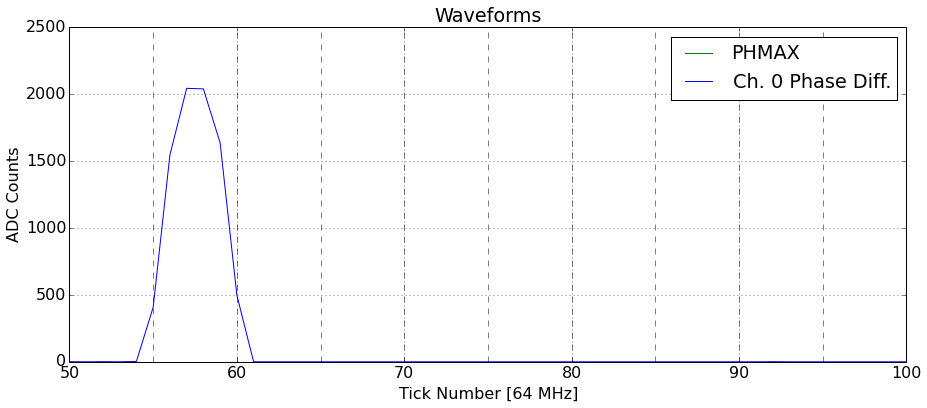

Emulator fire @ -1


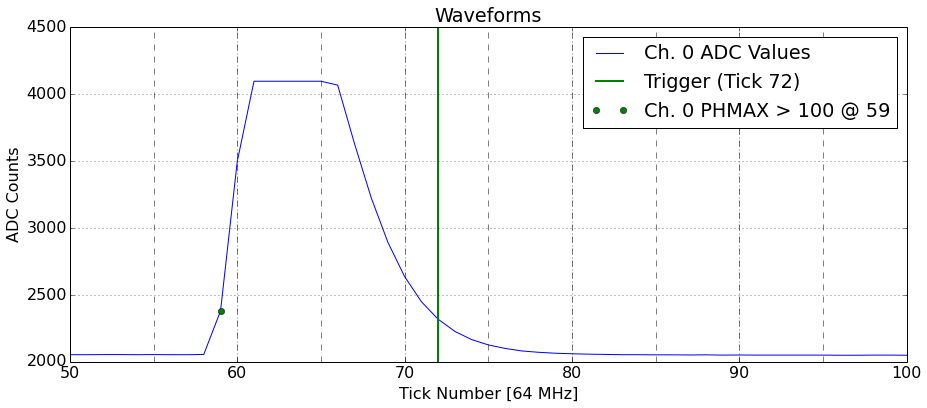

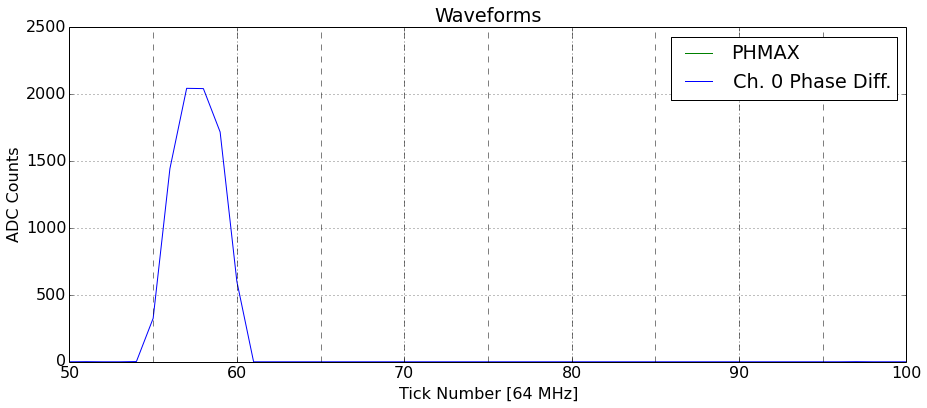

Emulator fire @ 56
Emulator fire @ 56
Emulator fire @ 56
Emulator fire @ 58
Emulator fire @ 58
Emulator fire @ 58
Emulator fire @ 58
Emulator fire @ 58
Emulator fire @ 59
Emulator fire @ 59
Emulator fire @ 59
Emulator fire @ 59
Emulator fire @ 59
Emulator fire @ 60
Emulator fire @ 60
Emulator fire @ 60
Emulator fire @ 61
Emulator fire @ 62
Emulator fire @ 62
Emulator fire @ 62
Emulator fire @ 62
Emulator fire @ 62
Emulator fire @ 63
Emulator fire @ 63
Emulator fire @ 64
Emulator fire @ 65
Emulator fire @ 65
Emulator fire @ 65
Emulator fire @ 65
Emulator fire @ 66
Emulator fire @ 66
Emulator fire @ 66
Emulator fire @ 67
Emulator fire @ 67
Emulator fire @ 67
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 68
Emulator fire @ 69
Emulator fire @ 69
Emulator fire @ 69
Emulator fire @ 69
Emulator fire @ 69
Emulator fire @ 69
Emulator fire @ 71
Emulator fire @ 71


In [5]:
show_ch1 = False

# loop through xmit info
for x in xrange(t_xmit.GetEntries()):
    t_xmit.GetEntry(x)
    t_trig.GetEntry(x)
    ev_fifo = t_xmit.fifo_pmt_xmit_branch
    frame_num = sample_num = 0
    
    ch0,ch1,beamch=(None,None,None)

    for n in xrange(ev_fifo.size()):
        fifo = ev_fifo[n]
        if not fifo.module_address() == 5: continue
        channel = fifo.channel_number()
        
        if channel == 0: 
            ch0 = fifo
        elif channel == 1:
            ch1 = fifo
        elif channel in [46,47]:
            beamch = fifo

    ch0_adc = np.array(ch0)
    ch1_adc = np.array(ch1)
    beamch_adc = np.array(beamch)

    # Get timings
    beamgate_sample = ch0.readout_sample_number_RAW()
    
    trig_num = ev_fifo.event_number()
    trig_time,trig_frame,trig_sample = trig_times[trig_num]
    trig_tick = trig_sample - beamgate_sample

    beamch_tick = beamch.readout_sample_number_RAW() - beamgate_sample
    beamch_fire = getFireTick(beamch_adc)

    if trig_tick < 0 or trig_tick > 100: continue
        
    # Emulator
    emu_out = emu.Emulate(ev_fifo)
    print 'Emulator fire @',
    emu_fired = False
    for t in emu_out.fire_time_v:
        print t,
        if t >= 0: emu_fired = True
    print
    if emu_fired: continue
        
    #
    # Data plot
    #
    fig = plt.figure(figsize=(15,6))
        
    plt.plot(ch0,label='Ch. 0 ADC Values',color='b')
    
    plt.axvline(trig_tick,color='g',lw=2,label='Trigger (Tick %d)' % trig_tick)
            
    # get saturation tick for ch1
    ch0_fire = getFireTick(ch0_adc)
    plt.plot(ch0_fire,ch0_adc[ch0_fire],'go',label='Ch. 0 PHMAX > 100 @ %d' % ch0_fire)
    if show_ch1:
        ch1_fire = getFireTick(ch1_adc)
        plt.plot(ch1,label='Ch. 1 ADC Values ',color='r')
        plt.plot(ch1_fire,ch1_adc[ch1_fire],'go',label='Ch. 1 PHMAX > 100 @ %d' % ch1_fire)

    for x in xrange(100):
        plt.axvline(x*5,color='k',alpha=0.5,linestyle='--')
   
    plt.grid()
    plt.legend()
    plt.xlim(50,100)
    plt.xlabel('Tick Number [64 MHz]')
    plt.ylabel('ADC Counts')
    plt.title('Waveforms')
    plt.show()
    
    #
    # Emulator plot
    #
    fig = plt.figure(figsize=(15,6))

    phmax = emu.PHMAX()
    diff3 = emu.PhaseDiffDisc3(0)
    
    plt.plot(phmax,color='g',label='PHMAX')
    plt.plot(diff3,color='b',label='Ch. 0 Phase Diff.')
    for x in xrange(100):
        plt.axvline(x*5,color='k',alpha=0.5,linestyle='--')
    
    plt.grid()
    plt.legend()
    plt.xlim(50,100)
    plt.xlabel('Tick Number [64 MHz]')
    plt.ylabel('ADC Counts')
    plt.title('Waveforms')
    plt.show()


Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ 71
Emulator fire @ 71
Emulator fire @ 71
Emulator fire @ 71
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1
Emulator fire @ -1


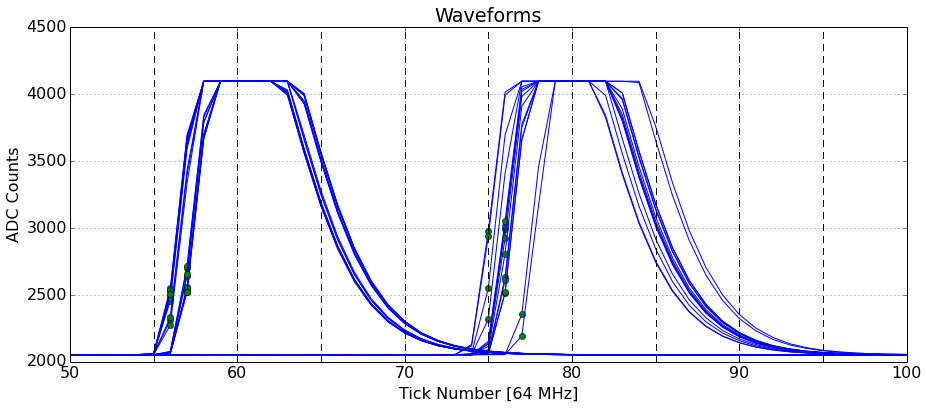

In [6]:
show_ch1 = False
fig = plt.figure(figsize=(15,6))
# loop through xmit info
for x in xrange(t_xmit.GetEntries()):
    t_xmit.GetEntry(x)
    t_trig.GetEntry(x)
    ev_fifo = t_xmit.fifo_pmt_xmit_branch
    frame_num = sample_num = 0
    
    ch0,ch1,beamch=(None,None,None)

    for n in xrange(ev_fifo.size()):
        fifo = ev_fifo[n]
        if not fifo.module_address() == 5: continue
        channel = fifo.channel_number()
        
        if channel == 0: 
            ch0 = fifo
        elif channel == 1:
            ch1 = fifo
        elif channel in [46,47]:
            beamch = fifo

    ch0_adc = np.array(ch0)
    ch1_adc = np.array(ch1)
    beamch_adc = np.array(beamch)

    # Get timings
    beamgate_sample = ch0.readout_sample_number_RAW()
    
    trig_num = ev_fifo.event_number()
    trig_time,trig_frame,trig_sample = trig_times[trig_num]
    trig_tick = trig_sample - beamgate_sample

    beamch_tick = beamch.readout_sample_number_RAW() - beamgate_sample
    beamch_fire = getFireTick(beamch_adc)

    if trig_tick < 100 and trig_tick>0: continue
        
    plt.plot(ch0,label='Ch. 0 ADC Values',color='b')
    #plt.plot(ch1,label='ch1',color='g')
    
    #plt.axvline(trig_tick,color='r',lw=2,label='Trigger (Tick %d)' % trig_tick)
            
    # get saturation tick for ch1
    ch0_fire = getFireTick(ch0_adc)
    plt.plot(ch0_fire,ch0_adc[ch0_fire],'go',label='PHMAX > 100 @ %d' % ch0_fire)
    
    if show_ch1:
        ch1_fire = getFireTick(ch1_adc)
        plt.plot(ch1,label='Ch. 1 ADC Values ',color='r')
        plt.plot(ch1_fire,ch1_adc[ch1_fire],'go',label='Ch. 1 PHMAX > 100 @ %d' % ch1_fire)
    
    for x in xrange(100):
        plt.axvline(x*5,color='k',alpha=0.5,linestyle='--')
            
            
    # Emulator
    emu_out = emu.Emulate(ev_fifo)
    print 'Emulator fire @',
    for t in emu_out.fire_time_v:
        print t,
    print
    
plt.grid()
#plt.legend()
plt.xlim(50,100)
plt.xlabel('Tick Number [64 MHz]')
plt.ylabel('ADC Counts')
plt.title('Waveforms')
plt.show()

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 56
Trigger fire     @ 608.0
Emulator fire @ -1
<ROOT.vector<short> object at 0x7fc54669ad70>


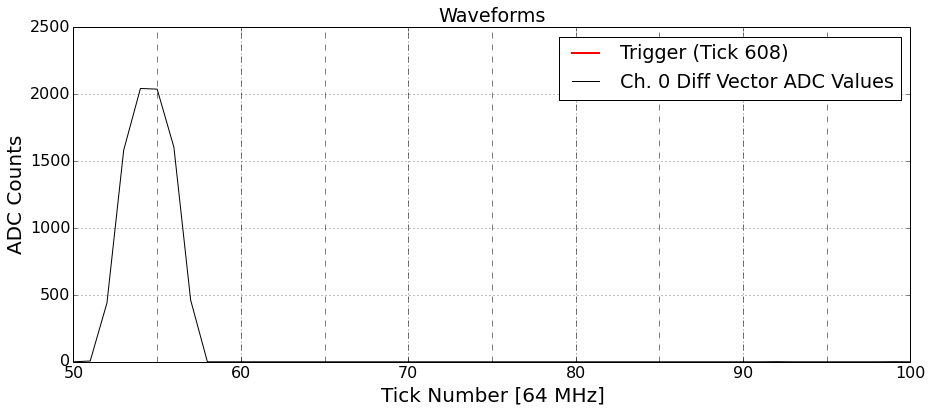

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 57
Trigger fire     @ 608.0
Emulator fire @ -1
<ROOT.vector<short> object at 0x7fc54669ad70>


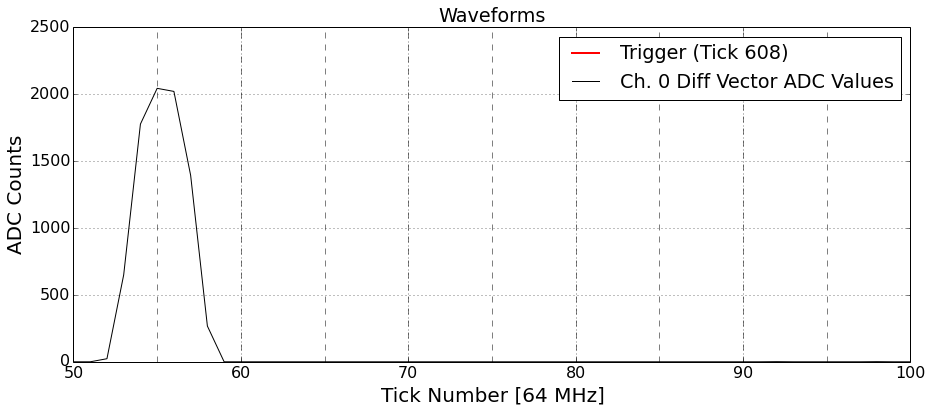

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 58
Trigger fire     @ 71.0
Emulator fire @ -1
<ROOT.vector<short> object at 0x7fc54669ad70>


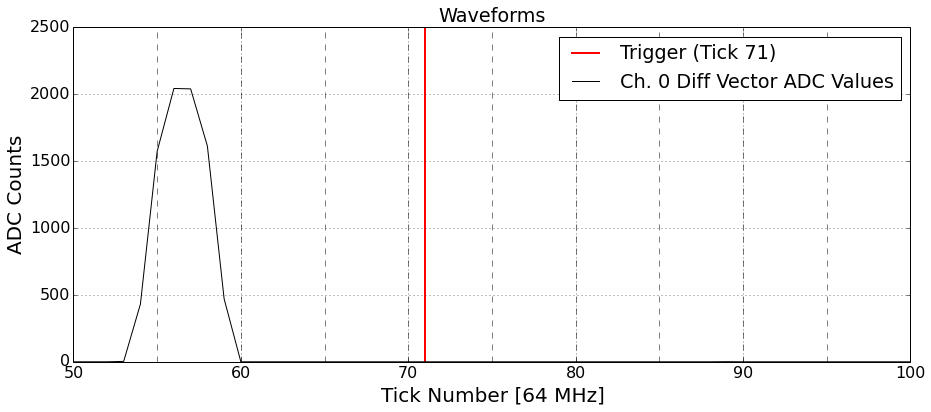

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 59
Trigger fire     @ 71.0
Emulator fire @ -1
<ROOT.vector<short> object at 0x7fc54669ad70>


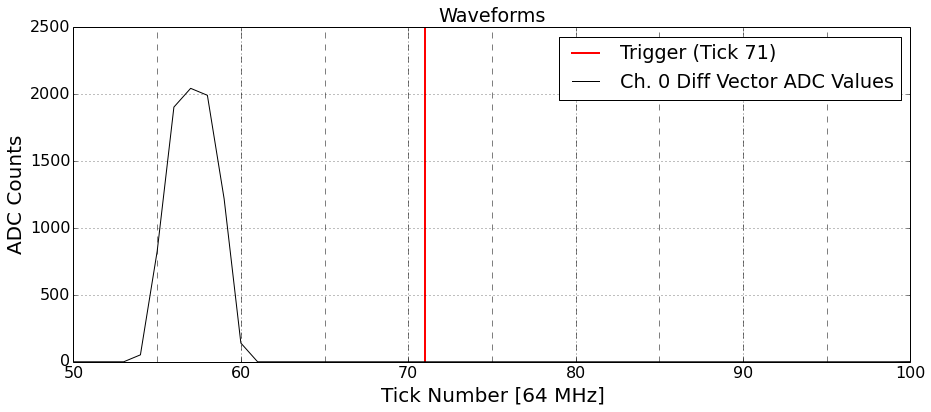

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 60
Trigger fire     @ 72.0
Emulator fire @ 56
<ROOT.vector<short> object at 0x7fc54669ad70>


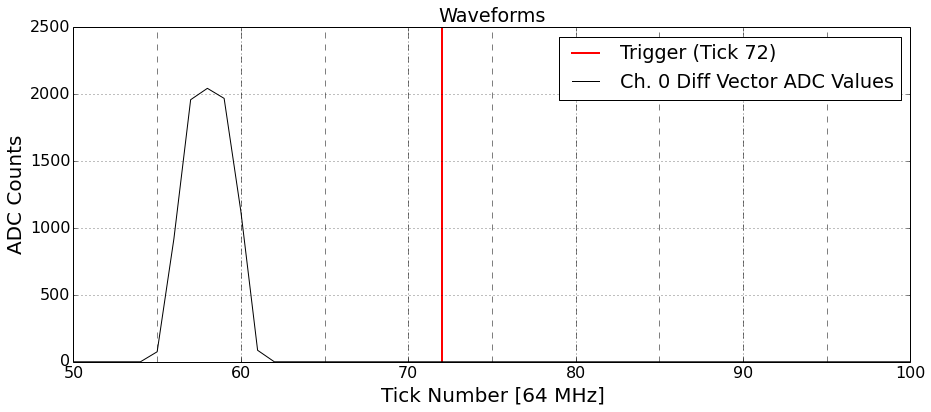

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 61
Trigger fire     @ 74.0
Emulator fire @ 58
<ROOT.vector<short> object at 0x7fc54669ad70>


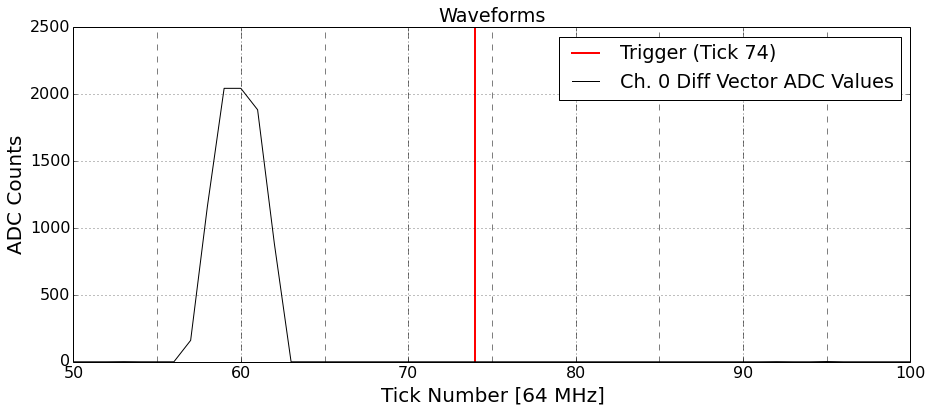

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 62
Trigger fire     @ 74.0
Emulator fire @ 58
<ROOT.vector<short> object at 0x7fc54669ad70>


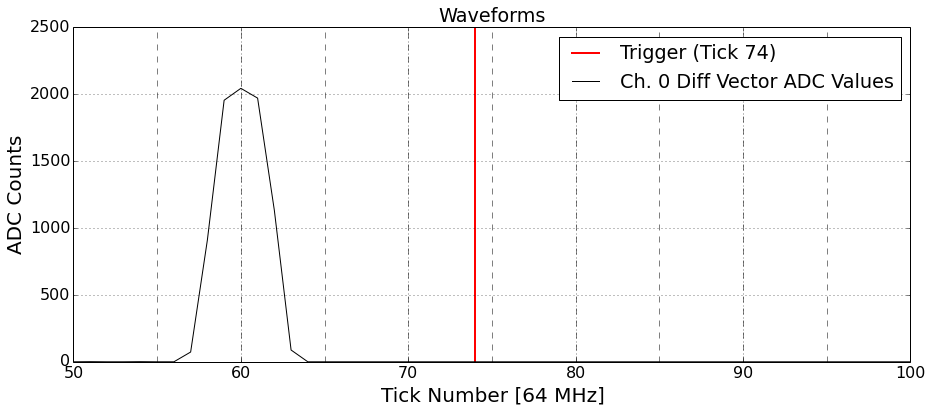

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 63
Trigger fire     @ 75.0
Emulator fire @ 59
<ROOT.vector<short> object at 0x7fc54669ad70>


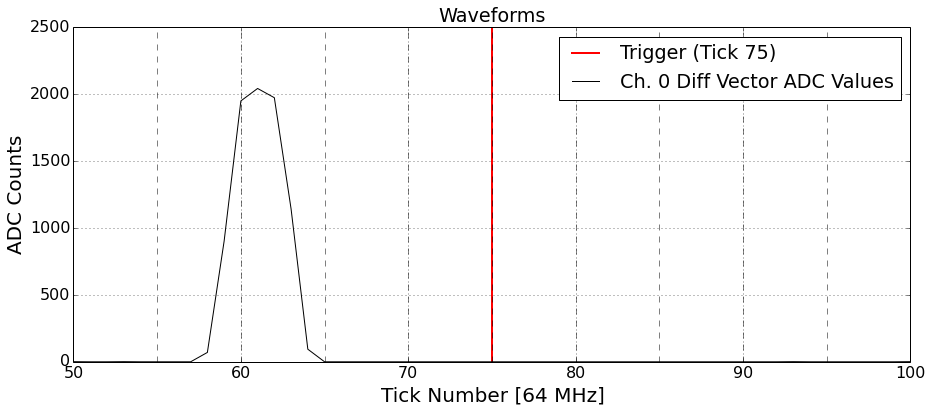

BeamCh Start     @ -17
BeamCh PHMax>100 @ -14
Ch. 0 fire       @ 64
Trigger fire     @ 76.0
Emulator fire @ 60
<ROOT.vector<short> object at 0x7fc54669ad70>


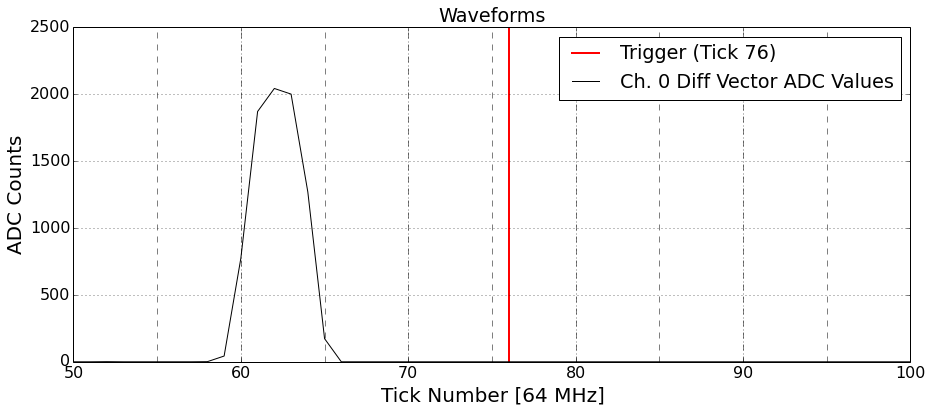

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 65
Trigger fire     @ 78.0
Emulator fire @ 61
<ROOT.vector<short> object at 0x7fc54669ad70>


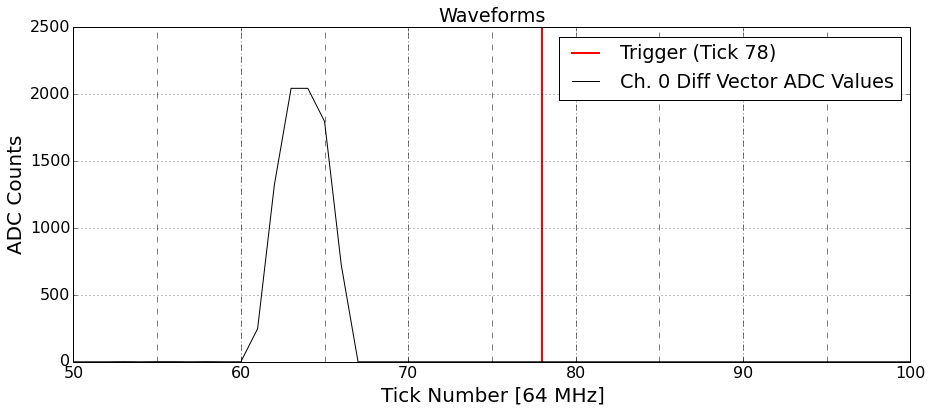

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 66
Trigger fire     @ 78.0
Emulator fire @ 62
<ROOT.vector<short> object at 0x7fc54669ad70>


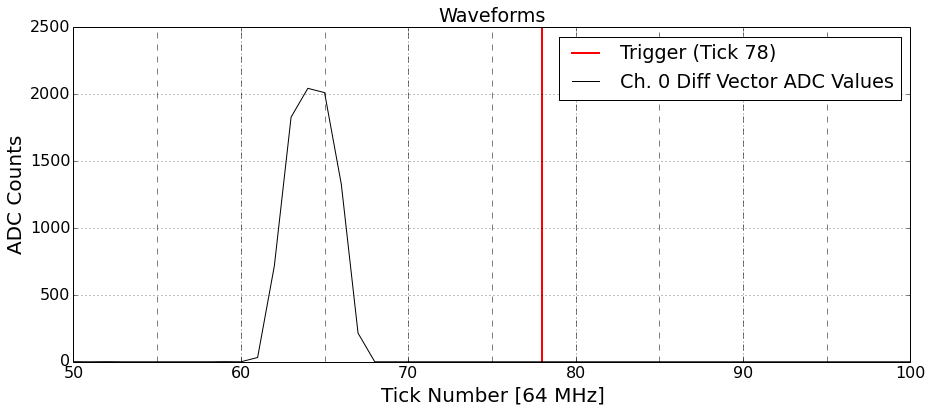

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 67
Trigger fire     @ 79.0
Emulator fire @ 63
<ROOT.vector<short> object at 0x7fc54669ad70>


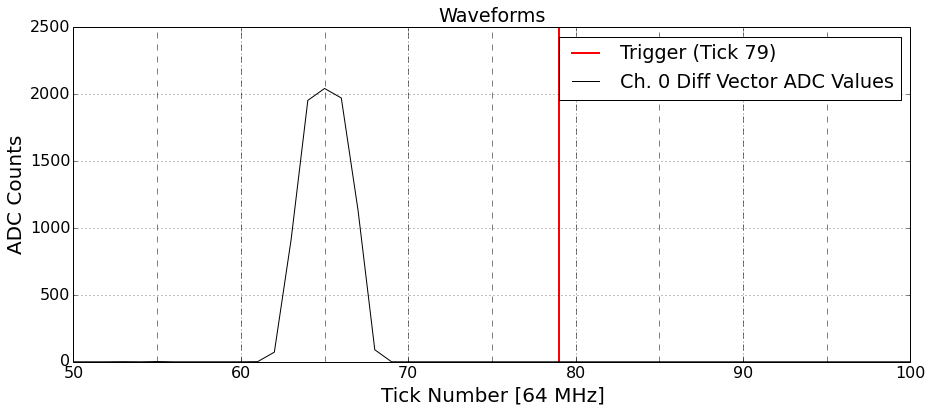

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 68
Trigger fire     @ 81.0
Emulator fire @ 64
<ROOT.vector<short> object at 0x7fc54669ad70>


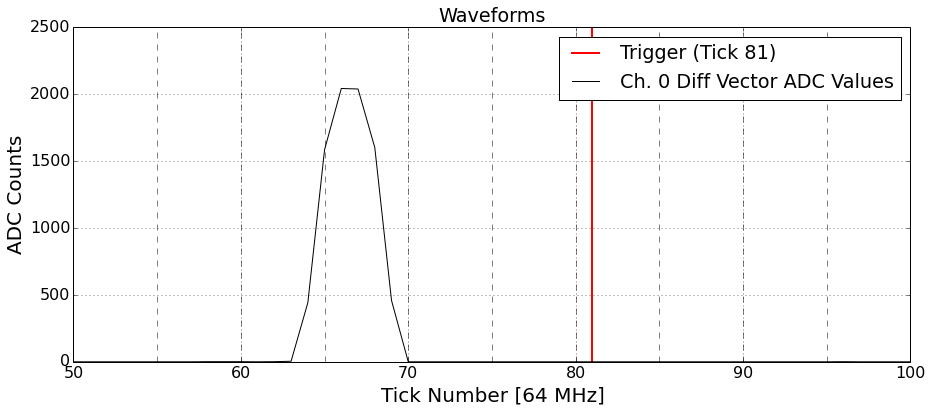

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 69
Trigger fire     @ 81.0
Emulator fire @ 65
<ROOT.vector<short> object at 0x7fc54669ad70>


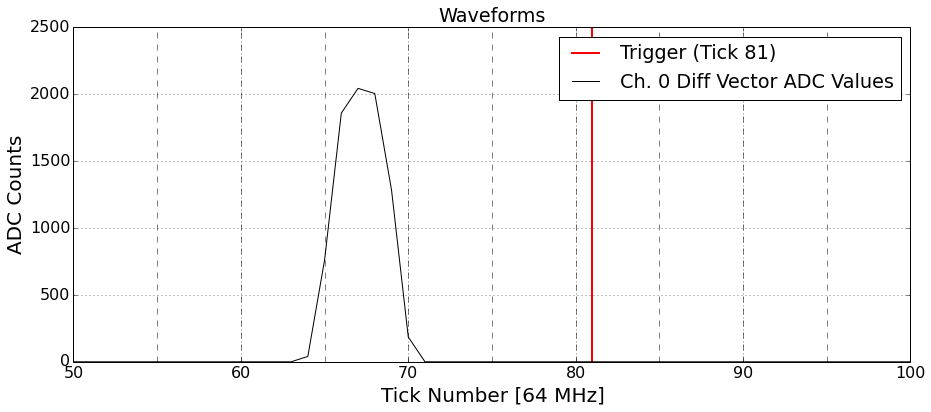

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 70
Trigger fire     @ 82.0
Emulator fire @ 66
<ROOT.vector<short> object at 0x7fc54669ad70>


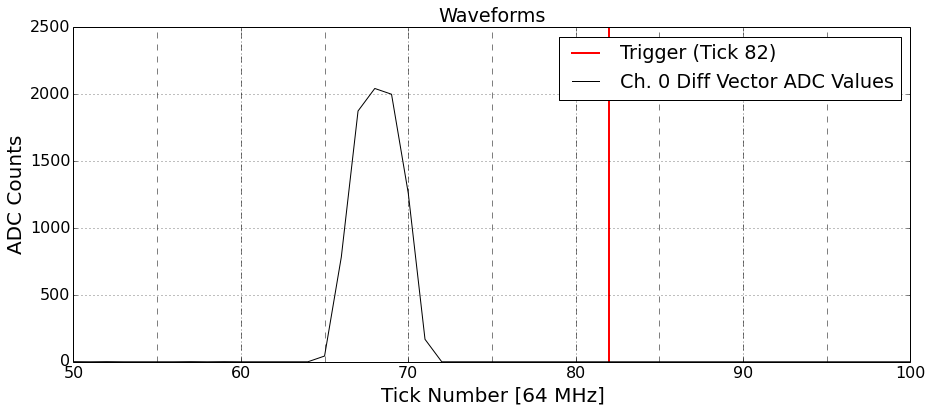

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 71
Trigger fire     @ 84.0
Emulator fire @ 67
<ROOT.vector<short> object at 0x7fc54669ad70>


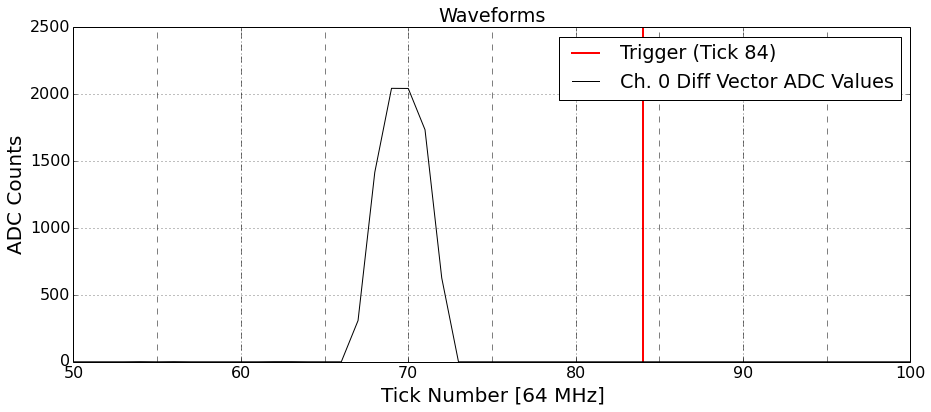

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 72
Trigger fire     @ 84.0
Emulator fire @ 68
<ROOT.vector<short> object at 0x7fc54669ad70>


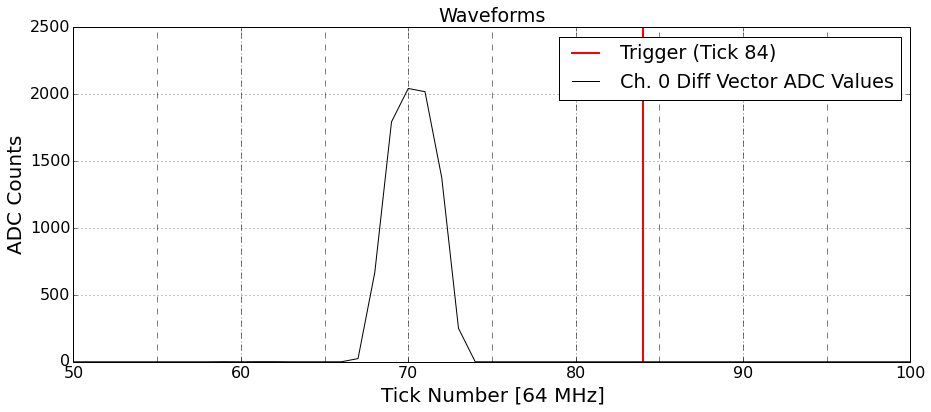

BeamCh Start     @ -17
BeamCh PHMax>100 @ -14
Ch. 0 fire       @ 73
Trigger fire     @ 85.0
Emulator fire @ 69
<ROOT.vector<short> object at 0x7fc54669ad70>


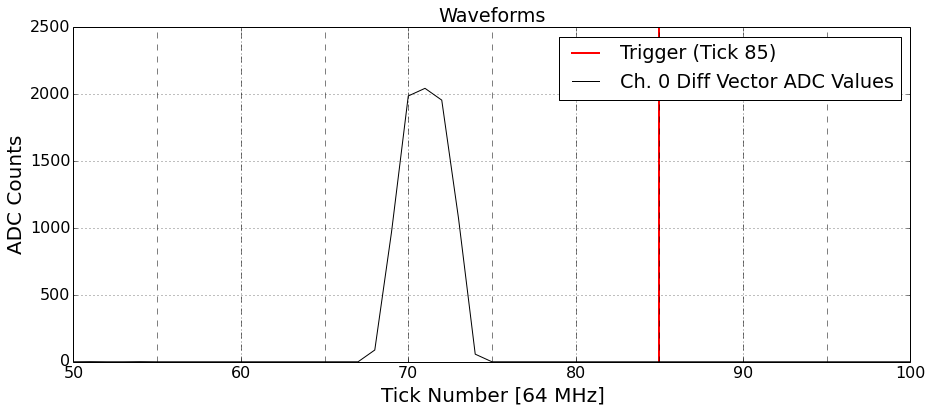

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 74
Trigger fire     @ 87.0
Emulator fire @ 71
<ROOT.vector<short> object at 0x7fc54669ad70>


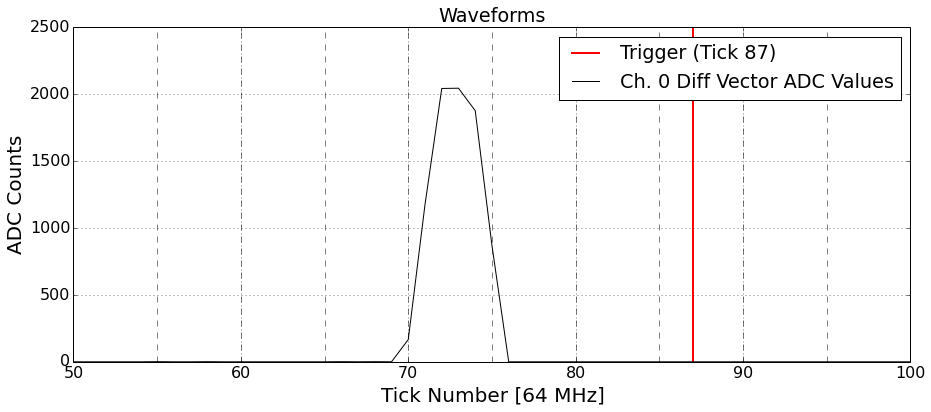

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 75
Trigger fire     @ 609.0
Emulator fire @ 71
<ROOT.vector<short> object at 0x7fc54669ad70>


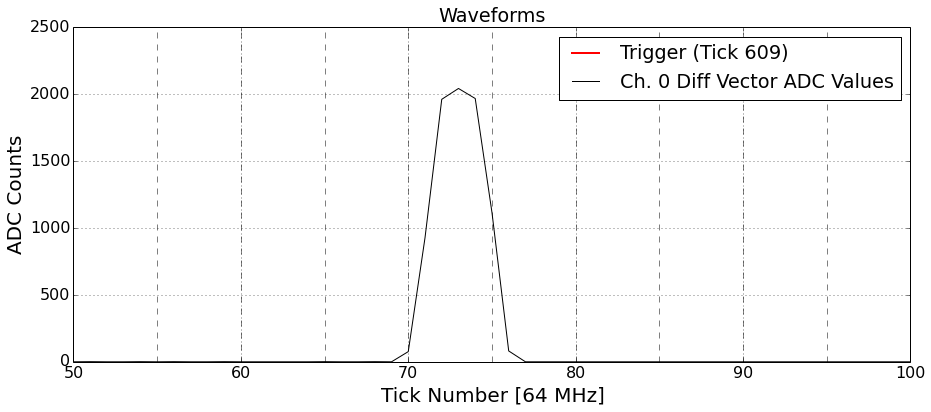

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 76
Trigger fire     @ 609.0
Emulator fire @ -1
<ROOT.vector<short> object at 0x7fc54669ad70>


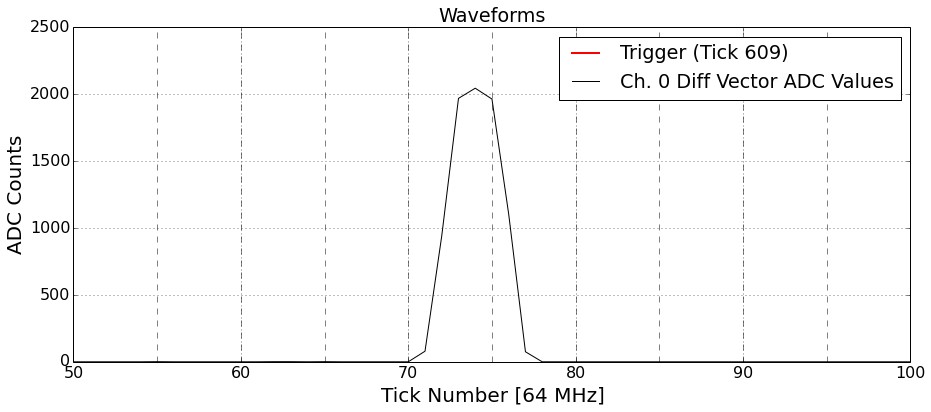

BeamCh Start     @ -16
BeamCh PHMax>100 @ -13
Ch. 0 fire       @ 77
Trigger fire     @ 609.0
Emulator fire @ -1
<ROOT.vector<short> object at 0x7fc54669ad70>


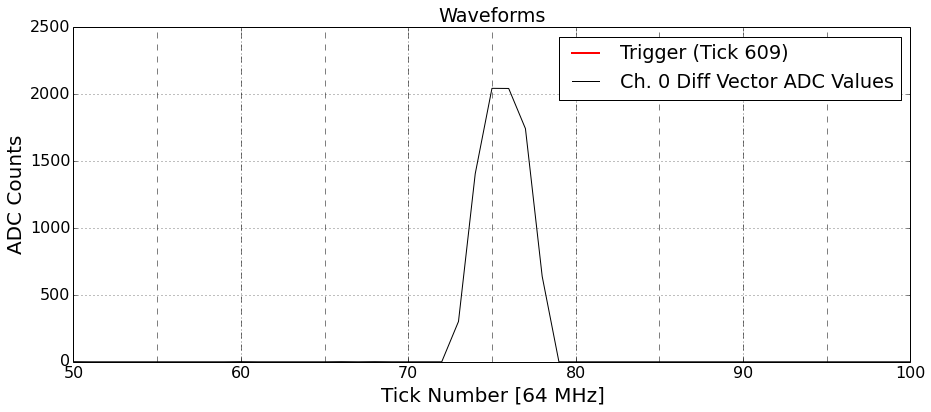

In [7]:
# loop through xmit info
fire_time_v = []
show_ch1 = False
for x in xrange(t_xmit.GetEntries()):
    t_xmit.GetEntry(x)
    t_trig.GetEntry(x)
    ev_fifo = t_xmit.fifo_pmt_xmit_branch
    frame_num = sample_num = 0
    
    ch0,ch1,beamch=(None,None,None)

    for n in xrange(ev_fifo.size()):
        fifo = ev_fifo[n]
        if not fifo.module_address() == 5: continue
        channel = fifo.channel_number()
        
        if channel == 0: 
            ch0 = fifo
        elif channel == 1:
            ch1 = fifo
        elif channel in [46,47]:
            beamch = fifo

    ch0_adc = np.array(ch0)
    ch1_adc = np.array(ch1)
    beamch_adc = np.array(beamch)

    #plt.plot(ch1,label='ch1',color='g')

    # Get timings
    beamgate_sample = ch0.readout_sample_number_RAW()
    
    trig_num = ev_fifo.event_number()
    trig_time,trig_frame,trig_sample = trig_times[trig_num]
    trig_tick = trig_sample - beamgate_sample

    beamch_tick = beamch.readout_sample_number_RAW() - beamgate_sample
    beamch_fire = getFireTick(beamch_adc)
            
    # get saturation tick for ch1
    ch0_fire = getFireTick(ch0_adc)
    if ch0_fire in fire_time_v: continue
        
    fig = plt.figure(figsize=(15,6))
    plt.axvline(trig_tick,color='r',lw=2,label='Trigger (Tick %d)' % trig_tick) 

    #plt.plot(ch0,label='Ch. 0 ADC Values',color='b')
    fire_time_v.append(ch0_fire)
    #plt.plot(ch0_fire,ch0_adc[ch0_fire],'go',label='Ch. 0 Disc3 @ %d' % ch0_fire)

    if show_ch1:
        ch1_fire = getFireTick(ch1_adc)
        plt.plot(ch1,label='Ch. 1 ADC Values ',color='r')
        plt.plot(ch1_fire,ch1_adc[ch1_fire],'go',label='Ch. 1 Disc3 @ %d' % ch1_fire)
    
    for x in xrange(100):
        plt.axvline(x*5,color='k',alpha=0.5,linestyle='--')

    print 'BeamCh Start     @', beamch_tick
    print 'BeamCh PHMax>100 @', beamch_tick + beamch_fire
    print 'Ch. 0 fire       @', ch0_fire
    print 'Trigger fire     @', trig_tick
         # Emulator
    emu_out = emu.Emulate(ev_fifo)
    print 'Emulator fire @',
    for t in emu_out.fire_time_v:
        print t,
    print
        
    diff3 = emu.PhaseDiffDisc3(0)
    plt.plot(diff3,label='Ch. 0 Diff Vector ADC Values',color='black')
    print diff3
    plt.grid()
    plt.legend()
    plt.xlim(50,100)
    plt.xlabel('Tick Number [64 MHz]',fontsize=20)
    plt.ylabel('ADC Counts',fontsize=20)
    plt.title('Waveforms')
    plt.show()